# DFSPy 函数使用演示
本 Notebook 展示 `dfspy_cores.py` 中各函数的典型用法，示例数据位于 `exampledata/`。

注意：
- 需要的依赖：numpy、matplotlib、obspy、pywt（仅 FWT 压缩需要）。
- 所有写文件的函数都会在输入文件所在目录自动创建形如 `DFSPy_cores_<task>_outputs/` 的子目录以保存结果。

**************************************************************************************  
软  件  名  称 : 分布式光纤传感数据处理软件 [简称： DFSPy] V1.0  
著  作  权  人 : 中国科学院半导体研究所(软件著作权登记号: 2025SR0353448)  
联  系  邮  箱 : qi.gh@outlook.com (开发者主页: https://github.com/chyiever)   
开  发  语  言 : Python 3.9+  
软  件  简  介：DFSPy 是一款专为科研人员设计的分布式光纤传感数据处理专业工具，致力于提供高效、可靠的数据处理解决方案。该软件集成了多种先进的数据处理算法，支持分布式光纤传感系统采集数据的预处理、分析与可视化，助力科研人员深入挖掘数据价值，加速研究进程。  
使  用  声  明：
1. 本软件为中国科学院半导体研究所开发的开源科研工具，仅供学术研究与非商业用途,用户使用本软件时，须遵守国家相关法律法规及科研道德规范，不得用于任何商业活动或非法用途。  
2. 软件以现状提供，开发者不对其适用性、完整性或准确性做出任何明示或暗示的保证。  
3. 如需引用本软件进行学术成果发表，请注明软件来源及开发者信息。  
***************************************************************************************  

## 0. 导入相关的库和依赖检查

### 函数调用说明
- convert_format(input_path, output_format, headfile_path=None):
  - txt -> MSEED/SAC 需提供 headfile_path；SAC/MSEED 可互转或导出 TXT。
- filter_stream(input, mode, kind, freqs, order=4, zerophase=True):
  - mode: 'bandpass'|'lowpass'|'highpass'|'bandstop'
  - freqs: bandpass/bandstop 用 (fmin, fmax)；low/high 用 (fcut, None)
  - kind 目前采用 ObsPy 默认 IIR（butterworth 为常用）
- advanced_denoise(input, method='wavelet', wavelet='db4', level=None, threshold=None, thr_mode='soft'):
  - 小波阈值降噪；threshold None 时自动估计。
- strain_to_velocity(input, apparent_velocity, normalize_divisor=5000.0):
  - 应变 -> 速度；apparent_velocity 单位 m/s。
- compress_fwt_txt(txt_path, wavelet='haar'):
  - FWT 压缩，返回 (pkl_path, ratio_percent)。
- decompress_fwt_to_txt(pkl_path, out_txt_name=None):
  - FWT 解压重构为 txt。
- plot_array(data, title=None); plot_stream(stream, title=None):
  - 诸道波形图；y 轴样点倒轴，便于对比。

提示：所有写文件的函数会在输入文件同级生成 DFSPy_<task>_outputs 目录。

**`_self_check_dependencies()`函数说明：**
- **功能：** 自动检查DASpy所需的所有依赖库是否已安装
- **输入：** 无参数
- **输出：** 在控制台输出依赖检查结果，缺少依赖时会给出安装提示

In [2]:
# 导入, 环境版本信息
import os, sys , matplotlib, obspy, pywt, numpy as np

print(f"Python 版本: {sys.version}") 
print(f"NumPy 版本: {np.__version__}")
print(f"Matplotlib 版本: {matplotlib.__version__}")
print(f"ObsPy 版本: {obspy.__version__}")
print(f"PyWavelets 版本: {pywt.__version__}")


from dfspy_cores import (
    _self_check_dependencies,  read_headfile, read_txt_array, read_stream, array_to_stream_from_head,
    plot_array, plot_stream,  convert_format, bandpass_denoise, filter_stream, advanced_denoise, 
    correlation_denoise, spectral_subtraction_denoise, strain_to_velocity,
    compress_fwt_txt, decompress_fwt_to_txt, gzip_compress, gzip_decompress
)
_self_check_dependencies()

# print("\n=== 测试环境配置完成 ===")


Python 版本: 3.9.19 (main, May  6 2024, 20:12:36) [MSC v.1916 64 bit (AMD64)]
NumPy 版本: 1.26.4
Matplotlib 版本: 3.8.4
ObsPy 版本: 1.4.1
PyWavelets 版本: 1.6.0


{'matplotlib': True, 'obspy': True, 'pywt': True, 'numpy': True}

## 1. 数据读取
- 从 txt 读取二维数组（列为道，行为样点）
- 从 SAC/MSEED 读取 ObsPy Stream

**`read_txt_array()`函数说明：**
- **功能：** 从txt文件读取二维数组数据，用于加载DAS数据
- **输入：** txt文件路径（字符串）
- **输出：** numpy二维数组，其中列为道（通道），行为时间样点

In [3]:
txt_path = os.path.join('exampledata', 'SemiTDM-DAS-100KHz 2023-8-8-1-24-14.732-9trace-20240328.txt')   # txt文件路径
headfile = os.path.join('exampledata', 'headfile.txt')  # headfile路径
arr = read_txt_array(txt_path)  # 读取txt文件为numpy数组
arr.shape   # 查看数组形状

(35000, 9)

## 2. 绘图
演示数组诸道图与 Stream 诸道图。Stream 由数组+头文件构建。

**`plot_array()`函数说明：**
- **功能：** 绘制二维数组的多道波形图，用于可视化DAS数据
- **输入：** 
  - data: 二维numpy数组（必需）
  - title: 图表标题（可选，默认None）
- **输出：** matplotlib图形对象，直接显示波形图  

**`read_headfile()`函数说明：**
- **功能：** 读取头文件信息，获取DAS数据的元信息
- **输入：** 头文件路径（字符串）
- **输出：** 包含采样率、起始时间等元信息的字典

**`array_to_stream_from_head()`函数说明：**
- **功能：** 将numpy数组和头文件信息结合，转换为ObsPy Stream对象
- **输入：** 
  - arr: 二维numpy数组
  - head: 头文件信息字典
- **输出：** ObsPy Stream对象，便于后续处理和分析

**`plot_stream()`函数说明：**
- **功能：** 绘制ObsPy Stream对象的多道波形图
- **输入：**
  - stream: ObsPy Stream对象（必需）
  - title: 图表标题（可选，默认None）
- **输出：** matplotlib图形对象，直接显示波形图

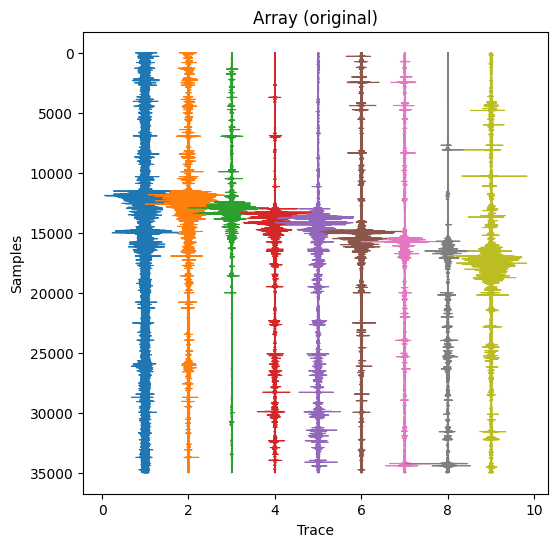

In [4]:
_ = plot_array(arr, title='Array (original)')   # 绘制数组图像

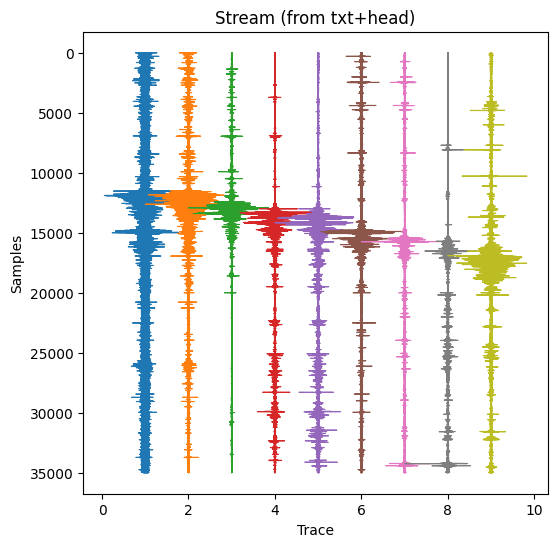

In [5]:
head = read_headfile(headfile)  # 读取headfile
st = array_to_stream_from_head(arr, head)   # 将数组和headfile转换为Stream对象
_ = plot_stream(st, title='Stream (from txt+head)') # 绘制Stream图像

## 3. 格式转换
- txt -> MSEED/SAC（需要头文件）
- MSEED/SAC -> 互转 或 -> txt

**`convert_format()`函数说明：**
- **功能：** 在不同数据格式间进行转换（TXT、MSEED、SAC）
- **输入：**
  - input_path: 输入文件路径（字符串）
  - output_format: 目标格式，'MSEED'、'SAC'或'TXT'
  - headfile_path: 头文件路径（从TXT转换时必需，其他情况可选）
- **输出：** 转换后的文件路径（字符串）

In [5]:
mseed_out = convert_format(txt_path, 'MSEED', headfile_path=headfile)
mseed_out

'e:\\daspy_notebook_20251015\\exampledata\\DFSPy_format_outputs\\SemiTDM-DAS-100KHz 2023-8-8-1-24-14.732-9trace-20240328.mseed'

In [6]:
# MSEED -> SAC
sac_out = convert_format(mseed_out, 'SAC')
sac_out

'e:\\daspy_notebook_20251015\\exampledata\\DFSPy_format_outputs\\SemiTDM-DAS-100KHz 2023-8-8-1-24-14.732-9trace-20240328.sac'

In [7]:
# MSEED -> TXT
txt_out = convert_format(mseed_out, 'TXT')
txt_out

'e:\\daspy_notebook_20251015\\exampledata\\DFSPy_format_outputs\\SemiTDM-DAS-100KHz 2023-8-8-1-24-14.732-9trace-20240328.txt'

## 4. 降噪

### 4.1 常规滤波
对 MSEED 执行带通滤波并保存输出。

**`filter_stream()`函数说明：**
- **功能：** 对ObsPy Stream对象进行数字滤波处理
- **输入：**
  - input: 输入文件路径或Stream对象
  - mode: 滤波模式，'bandpass'（带通）、'lowpass'（低通）、'highpass'（高通）、'bandstop'（带阻）
  - kind: 滤波器类型（如'butterworth'，当前使用ObsPy默认IIR）
  - freqs: 频率参数，带通/带阻用(fmin, fmax)，低通/高通用(fcut, None)
  - order: 滤波器阶数（默认4）
  - zerophase: 是否零相位滤波（默认True）
- **输出：** 滤波后的文件路径（字符串）

In [8]:
# 可配置滤波演示：Bandpass Butterworth，4阶，零相位
# 你也可以切换 mode 为 'lowpass'/'highpass'/'bandstop'，并调整 freqs 与 order。
# kind 当前预留（butterworth/cheby1），此处使用 ObsPy 默认 IIR。

denoised = filter_stream(
    mseed_out,
    mode='bandpass',
    kind='butterworth',
    freqs=(20, 200.0),  # (fmin, fmax) for bandpass/bandstop；low/high 仅需 (fcut, None)
    order=4,
    zerophase=True,
)
denoised

d:\anaconda3\envs\LZdataread39\lib\site-packages\obspy\io\mseed\core.py:773: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


'e:\\daspy_notebook_20251015\\exampledata\\DFSPy_denoise_outputs\\SemiTDM-DAS-100KHz 2023-8-8-1-24-14.732-9trace-20240328_bandpass_o4_20-200Hz.mseed'

9 Trace(s) in Stream:
DA.sea..01 | 2023-08-01T00:20:03.000000Z - 2023-08-01T00:20:03.349990Z | 100000.0 Hz, 35000 samples
DA.sea..02 | 2023-08-01T00:20:03.000000Z - 2023-08-01T00:20:03.349990Z | 100000.0 Hz, 35000 samples
DA.sea..03 | 2023-08-01T00:20:03.000000Z - 2023-08-01T00:20:03.349990Z | 100000.0 Hz, 35000 samples
DA.sea..04 | 2023-08-01T00:20:03.000000Z - 2023-08-01T00:20:03.349990Z | 100000.0 Hz, 35000 samples
DA.sea..05 | 2023-08-01T00:20:03.000000Z - 2023-08-01T00:20:03.349990Z | 100000.0 Hz, 35000 samples
DA.sea..06 | 2023-08-01T00:20:03.000000Z - 2023-08-01T00:20:03.349990Z | 100000.0 Hz, 35000 samples
DA.sea..07 | 2023-08-01T00:20:03.000000Z - 2023-08-01T00:20:03.349990Z | 100000.0 Hz, 35000 samples
DA.sea..08 | 2023-08-01T00:20:03.000000Z - 2023-08-01T00:20:03.349990Z | 100000.0 Hz, 35000 samples
DA.sea..09 | 2023-08-01T00:20:03.000000Z - 2023-08-01T00:20:03.349990Z | 100000.0 Hz, 35000 samples


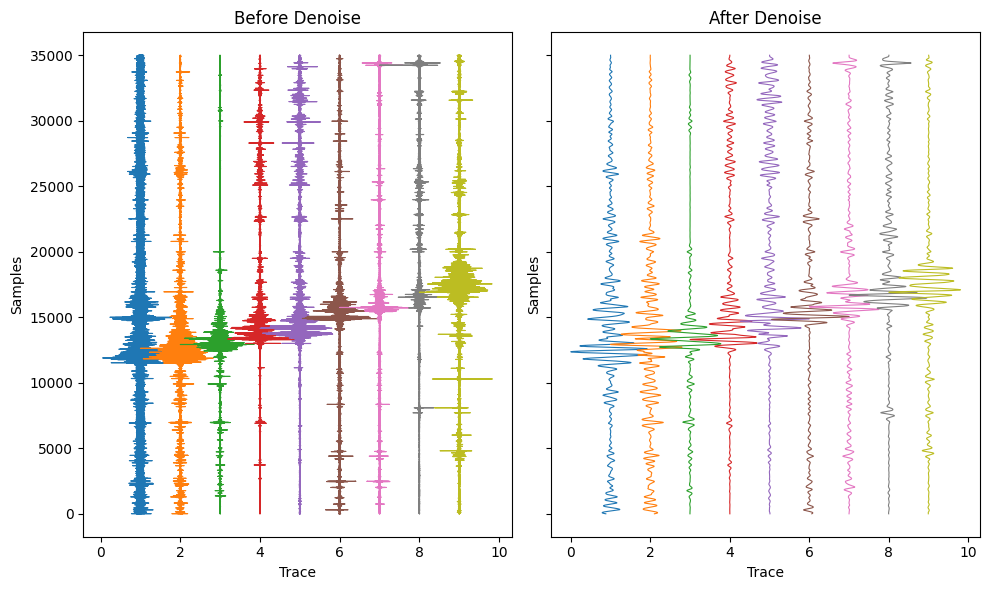

In [9]:
# 可视化：降噪前后对比
import matplotlib.pyplot as plt
from obspy import read as _read

st_orig = _read(mseed_out)
st_deno = _read(denoised)


print(st_orig)
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
plot_stream(st_orig, title='Before Denoise', ax=axes[0])
plot_stream(st_deno, title='After Denoise', ax=axes[1])
plt.tight_layout()

### 4.2 小波降噪
对每道采用小波分解+阈值去噪，自动估计阈值（可改 wavelet/level/threshold/thr_mode）。

**`advanced_denoise()`函数说明：**
- **功能：** 使用小波变换进行高级降噪处理
- **输入：**
  - input: 输入文件路径或Stream对象
  - method: 降噪方法（目前支持'wavelet'）
  - wavelet: 小波基函数（如'db4'、'haar'等，默认'db4'）
  - level: 小波分解层数（None表示自动选择）
  - threshold: 阈值（None表示自动估计）
  - thr_mode: 阈值处理模式（'soft'软阈值或'hard'硬阈值）
- **输出：** 降噪后的文件路径（字符串）

In [10]:
# 小波阈值降噪示例：db4，小波分解层数自动；软阈值
# 输出文件在与 mseed_out 同级的 DASpy_denoise_outputs 下
adv_out = advanced_denoise(mseed_out, method='wavelet', wavelet='db4', level=4, threshold=None, thr_mode='soft')
adv_out

'e:\\daspy_notebook_20251015\\exampledata\\DFSPy_denoise_outputs\\SemiTDM-DAS-100KHz 2023-8-8-1-24-14.732-9trace-20240328_wd_db4_L4.mseed'

9 Trace(s) in Stream:
DA.sea..01 | 2023-08-01T00:20:03.000000Z - 2023-08-01T00:20:03.349990Z | 100000.0 Hz, 35000 samples
DA.sea..02 | 2023-08-01T00:20:03.000000Z - 2023-08-01T00:20:03.349990Z | 100000.0 Hz, 35000 samples
DA.sea..03 | 2023-08-01T00:20:03.000000Z - 2023-08-01T00:20:03.349990Z | 100000.0 Hz, 35000 samples
DA.sea..04 | 2023-08-01T00:20:03.000000Z - 2023-08-01T00:20:03.349990Z | 100000.0 Hz, 35000 samples
DA.sea..05 | 2023-08-01T00:20:03.000000Z - 2023-08-01T00:20:03.349990Z | 100000.0 Hz, 35000 samples
DA.sea..06 | 2023-08-01T00:20:03.000000Z - 2023-08-01T00:20:03.349990Z | 100000.0 Hz, 35000 samples
DA.sea..07 | 2023-08-01T00:20:03.000000Z - 2023-08-01T00:20:03.349990Z | 100000.0 Hz, 35000 samples
DA.sea..08 | 2023-08-01T00:20:03.000000Z - 2023-08-01T00:20:03.349990Z | 100000.0 Hz, 35000 samples
DA.sea..09 | 2023-08-01T00:20:03.000000Z - 2023-08-01T00:20:03.349990Z | 100000.0 Hz, 35000 samples


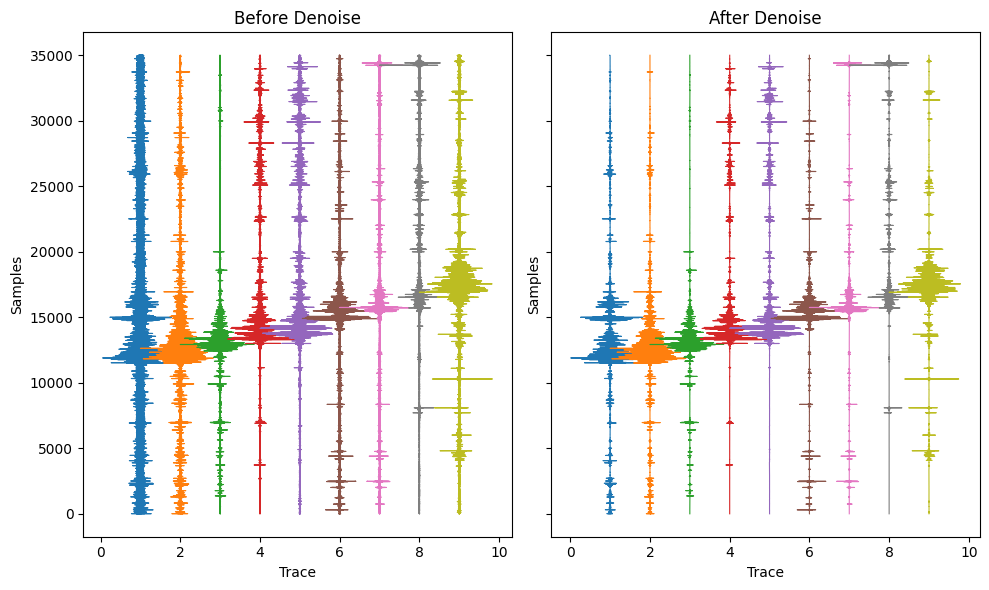

In [12]:
# 可视化：降噪前后对比
st_orig = _read(mseed_out)
st_deno = _read(adv_out)

print(st_orig)
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
plot_stream(st_orig, title='Before Denoise', ax=axes[0])
plot_stream(st_deno, title='After Denoise', ax=axes[1])
plt.tight_layout()

### 4.3 谱减法降噪
- 思路：对每道做 STFT，使用前若干帧估计噪声谱幅度，逐频谱减并设谱地板，最后 ISTFT 重构。
- 关键参数：
  - frame_length/hop_length：STFT 窗口长度与帧移
  - window：窗类型（如 'hann'）
  - noise_frames：用于估计噪声的前置帧数
  - alpha：谱减系数（>0），beta：谱地板比例（>=0）
- 输出：与输入同级的 `DFSpy_denoise_outputs/` 下生成后缀 `_specsub_...` 的文件。

**`spectral_subtraction_denoise()`函数说明：**
- **功能：** 使用谱减法进行降噪处理，基于短时傅里叶变换(STFT)
- **输入：**
  - input: 输入文件路径或Stream对象
  - frame_length: STFT窗口长度（默认1024）
  - hop_length: 帧移长度（默认512）
  - window: 窗函数类型（默认'hann'）
  - noise_frames: 用于估计噪声的前置帧数（默认10）
  - alpha: 谱减系数，大于0（默认1.0）
  - beta: 谱地板比例，大于等于0（默认0.02）
- **输出：** 降噪后的文件路径（字符串）

In [11]:
# 谱减法降噪：示例运行
specsub_out = spectral_subtraction_denoise(
    mseed_out,
    frame_length=1024,
    hop_length=512,
    window='hann',
    noise_frames=10,
    alpha=1.0,
    beta=0.02,
)
specsub_out

'e:\\daspy_notebook_20251015\\exampledata\\DFSPy_denoise_outputs\\SemiTDM-DAS-100KHz 2023-8-8-1-24-14.732-9trace-20240328_specsub_n10_a1_b0.02_whann_fl1024_hl512.mseed'

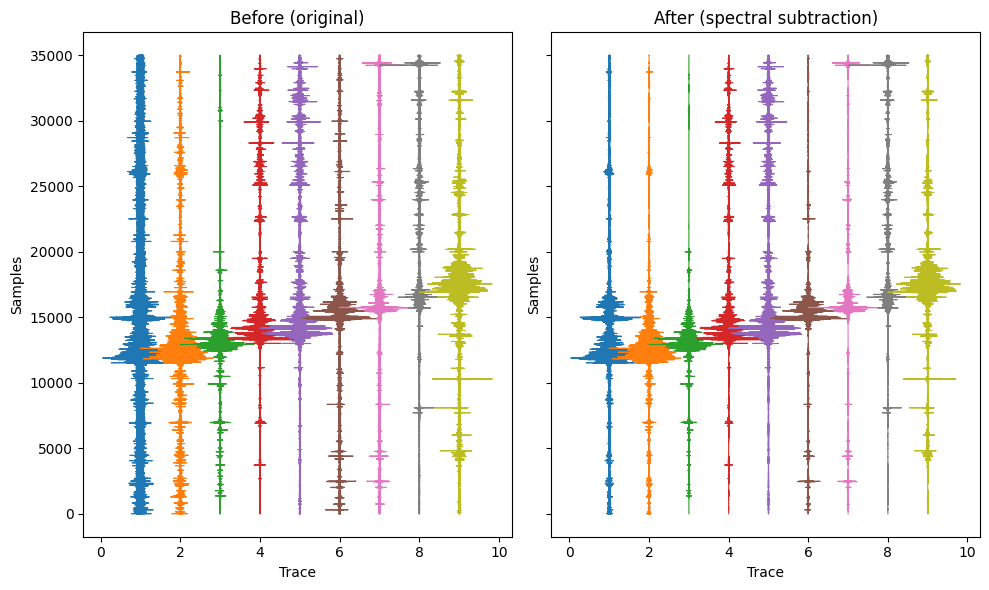

In [14]:
# 可视化：谱减法降噪前后对比
from obspy import read as _read
import matplotlib.pyplot as plt

st_orig = _read(mseed_out)
st_spec = _read(specsub_out)

fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
plot_stream(st_orig, title='Before (original)', ax=axes[0])
plot_stream(st_spec, title='After (spectral subtraction)', ax=axes[1])
plt.tight_layout()

### 4.4 基于空间相关性的降噪

- 思路：滑动窗口内计算通道间相关性，选择高相关的“信号道”构建信号模型，对各道进行噪声抑制。
- 关键参数：
  - window_size：窗口长度（采样点）
  - step_size：窗口步长（采样点）
  - corr_threshold：平均相关性阈值（0~1），越大越保守
- 输出：与输入同级的 `DASpy_denoise_outputs/` 下生成后缀 `_corr_w{w}_s{s}_t{thr}` 的文件。

**`correlation_denoise()`函数说明：**
- **功能：** 基于空间相关性进行降噪，利用通道间的相关性特征
- **输入：**
  - input: 输入文件路径或Stream对象
  - window_size: 滑动窗口长度（采样点数）
  - step_size: 窗口步长（采样点数）
  - corr_threshold: 平均相关性阈值（0~1），用于选择信号道
- **输出：** 降噪后的文件路径（字符串）

In [12]:
# 相关性降噪：示例运行
corr_out = correlation_denoise(
    mseed_out,
    window_size=5000,
    step_size=50,
    corr_threshold=0.3,
)
corr_out

'e:\\daspy_notebook_20251015\\exampledata\\DFSPy_denoise_outputs\\SemiTDM-DAS-100KHz 2023-8-8-1-24-14.732-9trace-20240328_corr_w5000_s50_t0.30.mseed'

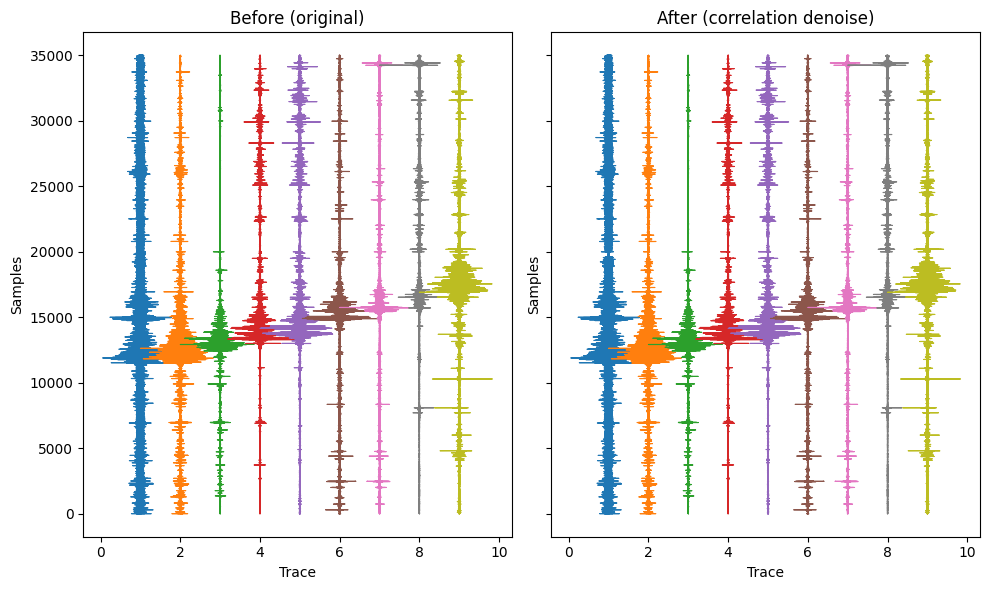

In [16]:
# 可视化：相关性降噪前后对比
from obspy import read as _read
import matplotlib.pyplot as plt

st_orig = _read(mseed_out)
st_corr = _read(corr_out)

fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
plot_stream(st_orig, title='Before (original)', ax=axes[0])
plot_stream(st_corr, title='After (correlation denoise)', ax=axes[1])
plt.tight_layout()

## 5. 参量转换（应变 -> 速度）

**`strain_to_velocity()`函数说明：**
- **功能：** 将DAS应变数据转换为速度数据
- **输入：**
  - input: 输入文件路径或Stream对象
  - apparent_velocity: 沿光缆的视速度，单位m/s
  - normalize_divisor: 归一化除数（默认5000.0）
- **输出：** 转换后的速度数据文件路径（字符串）

In [13]:
vel_out = strain_to_velocity(mseed_out, apparent_velocity=3500.0)
vel_out

'e:\\daspy_notebook_20251015\\exampledata\\DFSPy_paraconv_outputs\\SemiTDM-DAS-100KHz 2023-8-8-1-24-14.732-9trace-20240328_velocity.mseed'

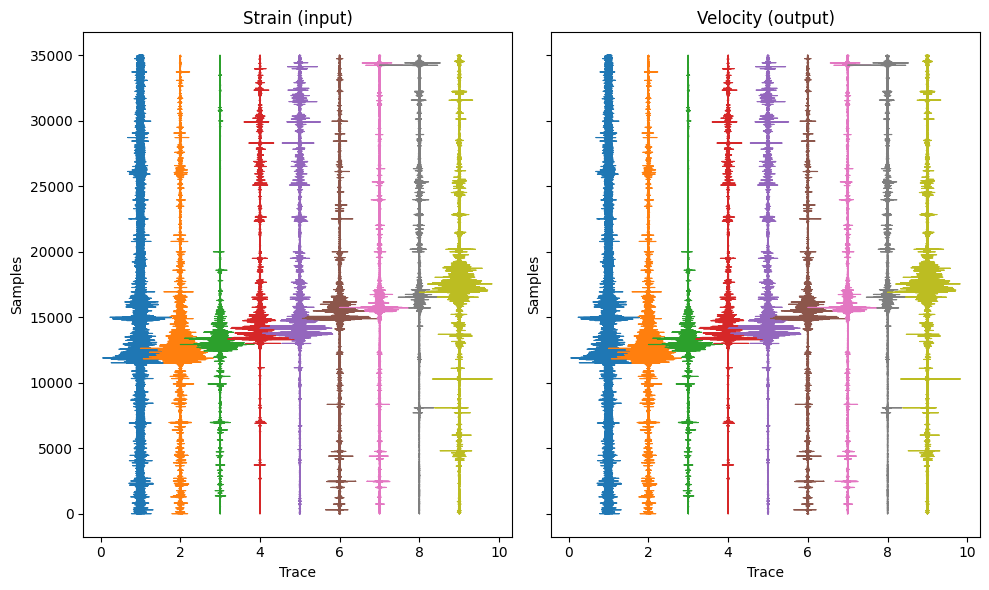

In [18]:
# 可视化：参量转换前后对比
from obspy import read as _read
st_vin = _read(mseed_out)
st_vout = _read(vel_out)

fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
plot_stream(st_vin, title='Strain (input)', ax=axes[0])
plot_stream(st_vout, title='Velocity (output)', ax=axes[1])
plt.tight_layout()

## 6. 压缩/解压

## 6.1. 使用快速小波变换(FWT)压缩

**`compress_fwt_txt()`函数说明：**
- **功能：** 使用快速小波变换(FWT)压缩txt文件中的数组数据
- **输入：**
  - txt_path: txt文件路径（字符串）
  - wavelet: 小波基函数（默认'haar'）
- **输出：** 元组(pkl_path, ratio_percent)，包含压缩文件路径和压缩率百分比

In [14]:
pkl_path, ratio = compress_fwt_txt(txt_path)
pkl_path, ratio

('e:\\daspy_notebook_20251015\\exampledata\\DFSPy_compress_outputs\\SemiTDM-DAS-100KHz 2023-8-8-1-24-14.732-9trace-20240328-coefficients.pkl',
 31.295006028899053)

In [15]:
# 打印压缩信息
src_size = os.path.getsize(txt_path)
cmp_size = os.path.getsize(pkl_path)
print(f"源文件: {txt_path}")
print(f"源大小: {src_size/1024/1024:.2f} MB")
print(f"压缩文件: {pkl_path}")
print(f"压缩大小: {cmp_size/1024/1024:.2f} MB")
print(f"压缩比: {cmp_size/src_size*100:.2f}%")

源文件: exampledata\SemiTDM-DAS-100KHz 2023-8-8-1-24-14.732-9trace-20240328.txt
源大小: 7.69 MB
压缩文件: e:\daspy_notebook_20251015\exampledata\DFSPy_compress_outputs\SemiTDM-DAS-100KHz 2023-8-8-1-24-14.732-9trace-20240328-coefficients.pkl
压缩大小: 2.41 MB
压缩比: 31.30%


**`decompress_fwt_to_txt()`函数说明：**
- **功能：** 将FWT压缩的pkl文件解压重构为txt文件
- **输入：**
  - pkl_path: 压缩的pkl文件路径（字符串）
  - out_txt_name: 输出txt文件名（可选，默认自动生成）
- **输出：** 解压后的txt文件路径（字符串）

In [16]:
recon_txt = decompress_fwt_to_txt(pkl_path)
recon_txt

'e:\\daspy_notebook_20251015\\exampledata\\DFSPy_decompress_outputs\\SemiTDM-DAS-100KHz 2023-8-8-1-24-14.732-9trace-20240328-coefficients-reconstructed.txt'

### 6.2. gzip算法压缩

**`gzip_compress()`函数说明：**
- **功能：** 使用GZIP算法压缩文件（通用文件压缩）
- **输入：** 
  - input_path: 待压缩的文件路径（字符串）
- **输出：** 压缩后的.gz文件路径（字符串）

In [17]:
gz = gzip_compress(txt_path)
gz

'e:\\daspy_notebook_20251015\\exampledata\\DFSPy_compress_outputs\\SemiTDM-DAS-100KHz 2023-8-8-1-24-14.732-9trace-20240328.txt.gz'

In [18]:
# 打印压缩信息
src_size = os.path.getsize(txt_path)
cmp_size = os.path.getsize(gz)
print(f"源文件: {txt_path}")
print(f"源大小: {src_size/1024/1024:.2f} MB")
print(f"压缩文件: {gz}")
print(f"压缩大小: {cmp_size/1024/1024:.2f} MB")
print(f"压缩比: {cmp_size/src_size*100:.2f}%")

源文件: exampledata\SemiTDM-DAS-100KHz 2023-8-8-1-24-14.732-9trace-20240328.txt
源大小: 7.69 MB
压缩文件: e:\daspy_notebook_20251015\exampledata\DFSPy_compress_outputs\SemiTDM-DAS-100KHz 2023-8-8-1-24-14.732-9trace-20240328.txt.gz
压缩大小: 3.29 MB
压缩比: 42.70%


In [19]:
ungz = gzip_decompress(gz)
ungz

'e:\\daspy_notebook_20251015\\exampledata\\DFSPy_decompress_outputs\\SemiTDM-DAS-100KHz 2023-8-8-1-24-14.732-9trace-20240328.txt'

                                             ** Statement **                                                  
*************************************************************************************************************  
Software Name         : Distributed Fiber Optic Sensing Data Processing Software [Abbreviation: DFSPy] V1.0  
Copyright Holder      : Institute of Semiconductors, Chinese Academy of Sciences  
Software Copyright Registration Number: 2025SR0353448  
Contact Email         : qi.gh@outlook.com  
Developer Homepage    : https://github.com/chyiever  
Creation Date         : 2025-09-25  
  
Software Introduction :DFSPy is a professional data processing tool designed for researchers working with  
    distributed fiber optic sensing systems. It aims to provide efficient and reliable data processing solutions,   
    integrating various advanced algorithms to support preprocessing, analysis, and visualization of data  
    collected by distributed fiber optic sensing systems. This tool helps researchers explore data value and  
    accelerate research progress.  
      
Usage Statement:  
  1. This software is an open-source research tool developed by the Institute of Semiconductors, CAS,   
     intended solely for academic research and non-commercial use.  
  2. Users must comply with relevant national laws, regulations, and research ethics when using this   
     software, and shall not use it for any commercial activities or illegal purposes.  
  3. The software is provided "as is" without any express or implied warranties regarding its applicability,  
     completeness, or accuracy.  
  4. Users shall independently evaluate and assume all risks arising from the use of this software. The   
      developers shall not be liable for any direct or indirect losses resulting from the use of this software.  
  5. When citing this software in academic publications, users are requested to appropriately acknowledge the  
     software source and developer information.  
*************************************************************************************************************  
